In [1]:
import sys
sys.path.append('/home/bodo/GitHub/NFProject/glow2/glow-pytorch')

In [2]:
from tqdm import tqdm, trange
import numpy as np
from PIL import Image
from math import log, sqrt, pi

import argparse
import pathlib

import torch
from torch import nn, optim
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils

import matplotlib.pyplot as plt
from train import sample_data
from model import Glow

from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
import cv2

/home/bodo/.pyenv/versions/3.8.16/envs/nf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils

In [3]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [4]:
def fit_range(data):
    data = data - data.min()
    data = data / data.max()
    return data

In [5]:
def prepare_model(args, 
                  path='/home/bodo/GitHub/NFProject/glow2/glow-pytorch/checkpoint/model_190001.pt'):
    model = Glow(
        3, args.n_flow, args.n_block, affine=args.affine, conv_lu=not args.no_lu
    )
    model = torch.nn.DataParallel(model)
    model.load_state_dict(torch.load(path))
    model = model.module.cpu()
    return model

In [6]:
def reverse(model, z):
    return model.reverse(z, reconstruct=True).detach()

In [7]:
def prepare_dataset(args):
    dataset = iter(sample_data(args.path, args.batch, args.img_size))
    X, y = next(dataset)
    return X, y

# Noise Generators

In [8]:
class GaussianNoise(torch.nn.Module):
    def __init__(self, var=1):
        super().__init__()
        self.std = torch.sqrt(var)

    def forward(self, clear):
        noise = torch.randn_like(clear)
        return (clear + self.std * noise).clip(0, 1)

In [9]:
class PoissonNaiveNoise(torch.nn.Module):
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha
    def forward(self, clear):
        return (self.alpha * torch.poisson(clear / self.alpha)).clip(0, 1)

In [10]:
class PoissonNoise(torch.nn.Module):
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha
    def forward(self, clear):
        return (clear + (self.alpha * clear).sqrt() * torch.randn_like(data)).clip(0, 1)

In [11]:
class PoissonGaussianNoise(torch.nn.Module):
    def __init__(self, alpha, var):
        super().__init__()
        self.alpha = alpha
        self.var = var
    def forward(self, clear):
        return (clear + (self.alpha * clear + self.var).sqrt() * torch.randn_like(clear)).clip(0, 1)

In [14]:
plt.imshow(X[0].permute(1,2,0))

NameError: name 'X' is not defined

In [15]:
plt.imshow(PoissonGaussianNoise(0.01, 0.00001)(X[0].unsqueeze(0).repeat(3,1,1,1)).detach()[0].permute(1,2,0))

NameError: name 'X' is not defined

# Image Priors

In [16]:
class LogNullPrior(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, data):
        return torch.tensor(0.0, dtype=torch.float)

In [17]:
class LogGaussianPrior(torch.nn.Module):
    def __init__(self,
                 mu=0,
                 sigma=1):
        super().__init__()
        self.mu = torch.tensor(mu).float()
        self.sigma = torch.tensor(sigma).float()
        
    def forward(self, data):
        return  - 0.5 * (data.exp() - self.mu).pow(2).sum(0).mul(self.sigma.pow(-1)).sum()

In [18]:
class GaussianPrior(torch.nn.Module):
    def __init__(self,
                 mu=0,
                 sigma=1):
        super().__init__()
        self.mu = torch.tensor(mu).float()
        self.sigma = torch.tensor(sigma).float()
        
    def forward(self, data):
        return  - 0.5 * (data - self.mu).pow(2).sum(0).mul(self.sigma.pow(-1)).sum()

In [19]:
class LogNormFlowPrior(torch.nn.Module):
    def __init__(self, model, leash=1.0):
        super().__init__()
        self.model = model
        self.leash = leash
    
    @staticmethod
    def preprocess(image, n_bits=5, n_bins=32):
        image = image * 255
    
        if n_bits < 8:
            # image = torch.floor(image / 2 ** (8 - n_bits))
            image = image / 2 ** (8 - n_bits)
    
        image = image / n_bins - 0.5
        return image
        
    def forward(self, data):
        logp, logdet, _ = self.model(LogNormFlowPrior.preprocess(data))
        # print(logdet)
        # print(logp)
        # print(logdet + logp)
        return self.leash * (logp + logdet).sum() / data.numel()

# Model

In [20]:
class NoiseModel(torch.nn.Module):
    def __init__(self, data, alpha=1.0, var=1.0, clear_prior=LogNullPrior()):
        super().__init__()
        
        # Parameters
        self.log_alpha = torch.nn.Parameter(torch.tensor(alpha, dtype=torch.float).log())
        self.log_sigma = torch.nn.Parameter(torch.tensor(var, dtype=torch.float).sqrt().log())
        self.clear = torch.nn.Parameter(
            data.mean(0, keepdim=True)
                .clip(0.01, 0.99)
                .logit()
                .detach()
        )

        # Priors
        self.clear_prior = clear_prior
        for p in self.clear_prior.parameters():
            p.requires_grad = False

    def get_params(self):
        return (
            self.log_alpha.exp().detach(),
            self.log_sigma.mul(2).exp().detach(),
            self.clear.sigmoid().detach(),
        )
        
    def forward(self, data):

        alpha = self.log_alpha.exp()
        clear = self.clear.sigmoid()
        sigma = self.log_sigma.exp()

        mean = clear
        var = (alpha * clear + sigma.square()).clip(1e-8)
        # var = (alpha * clear).clip(1e-8)
        
        log_likelihood = - 0.5 * (((data - mean).pow(2).mean(0, keepdim=True) / var).mean() + var.log().mean())
        log_prior = self.clear_prior(clear) / data.shape[0]

        return log_likelihood, log_prior

# Training Script

In [31]:
def denoise(model,
            noisy,
            iterations=1024,
            lr=0.01,
            opt=None,
            device='cpu',
            min_iter=10,
            precision=1e-6):

    model = model.to(device)
    noisy = noisy.to(device)
    
    # Init Opt
    opt = torch.optim.Adam(model.parameters(), lr=lr) if opt is None else opt
    print(model.get_params()[0:2])
    # Log
    metadata = {
        'log_likelihood': [],
        'log_prior': []
    }
    
    for iteration in (pbar := trange(iterations)):
        
        opt.zero_grad()

        log_likelihood, log_prior = model(noisy)
        
        loss = - (log_likelihood + log_prior)
        loss.backward()
        opt.step()

        metadata['log_likelihood'].append(log_likelihood.item())
        metadata['log_prior'].append(log_prior.item())
        
        pbar.set_description(f'log_likelihood : {log_likelihood.item():.05f}  | log_prior = {log_prior.item():.05f}')

        if iteration >= min_iter and abs(loss.item() + metadata['log_likelihood'][-2] + metadata['log_prior'][-2]) < precision:
            break

    return model.cpu(), metadata

# Measuring Image Quality

In [32]:
def to_array(image):
    image = image.squeeze()
    if len(image.shape) == 3:
        image = image.permute(1,2,0)
    image = image.numpy()
    return image

def to_gray(image):
    if type(image) is torch.Tensor: 
        image = to_array(image)
    if len(image.shape) == 2:
        return image
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [33]:
def compute_metrics(noisy, denoised, clear, measures):
    
    clear = to_gray(clear)
    denoised = to_gray(denoised)
    
    result = {
        name: {
            'denoised' : measure(clear, to_gray(denoised)),
            'noisy': [measure(clear, to_gray(noisy)) for noisy in noisy]
        }
        for name, measure in measures.items()
    }
    
    return result

# Comparison Script

In [34]:
import traceback

In [35]:
measures = {
    'mse' : mean_squared_error,
    'psnr': lambda x, y: peak_signal_noise_ratio(x, y, data_range=1),
    'ssim': lambda x, y: structural_similarity(x, y, data_range=1)
}

def create_comparison(clear,
                      alpha=0.01,
                      var=0.00001,
                      n_samples=64,
                      iterations=1024,
                      lr=0.1,
                      opt=None,
                      device='cpu',
                      repeat=1, 
                      measures=measures, 
                      clear_prior=LogNullPrior()):
    
    clear_prior = clear_prior.to(device)
    clear = clear.unsqueeze(0).to(device)
    noise_generator = PoissonGaussianNoise(alpha, var).to(device)
    
    stats = []

    for ind in range(repeat):
    
        noisy = noise_generator(clear.repeat(n_samples, 1, 1, 1))
        model = NoiseModel(noisy, alpha, var, clear_prior)
        # model = NoiseModel(noisy, 1.0, 0.1, clear_prior)
        
        model, metadata = denoise(
            model,
            noisy,
            iterations=iterations,
            lr=lr,
            device=device,
        )
        
        metrics = compute_metrics(
            noisy.cpu(),
            model.clear.data.cpu().sigmoid(),
            clear.cpu(),
            measures
        )
        
        
        stats.append({
            'clear': clear.cpu(),
            'noisy': noisy.cpu(),
            'model': model.cpu(),
            'metadata': metadata,
            'metrics': metrics,
        })
    
    return stats
                

In [36]:
args = Namespace(
      n_flow = 32
    , n_block = 4
    , affine = None
    , no_lu = None
    , lr = 1e-4
    , path = '/home/bodo/GitHub/NFProject/data/test'
    , batch = 32
    , img_size = 64
)
flow_model = prepare_model(args).cpu()
clear_prior = LogNormFlowPrior(flow_model)
# clear_prior = LogNullPrior()

In [37]:
clear_prior(X[0:1].repeat(16,1,1,1))

tensor(2.9394, grad_fn=<DivBackward0>)

In [38]:
torch.manual_seed(123)
X, y = prepare_dataset(args)

In [39]:
COMPARISON = dict()
for n_samples in [1, 4, 16, 32, 64]:
  for alpha in [0.0001, 0.001, 0.01, 0.1]:
    for var in [0.0001, 0.001, 0.01, 0.1]:
      for key, clear_prior in {'null': LogNullPrior(), 'nf': LogNormFlowPrior(flow_model, leash=1)}.items(): # }.items(): # 
        try: 
            clear = X[0]
            comparison = create_comparison(
                clear,
                alpha=alpha,
                var=var,
                n_samples=n_samples,
                clear_prior=clear_prior,
                iterations=1000,
                lr=0.01,
                device='cuda',
                repeat=1,
            )
            COMPARISON[(n_samples, alpha, var, key)] = comparison
            torch.save(comparison, f'analysis/{n_samples}_{alpha}_{var}_{key}.pt')
        except: 
            traceback.print_exc()

(tensor(1.0000e-04, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 8.89742  | log_prior = 0.00000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 380.97it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 8.76907  | log_prior = 2.55097: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:11<00:00,  5.22it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 8.92712  | log_prior = 0.00000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 377.45it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 2.37882  | log_prior = 4.08126: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:20<00:00,  5.00it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 8.33472  | log_prior = 0.00000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 364.11it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.63063  | log_prior = 4.42338:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 621/1000 [02:01<01:13,  5.13it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 8.77475  | log_prior = 0.00000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 363.71it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.82396  | log_prior = 4.08698: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:18<00:00,  5.04it/s]


(tensor(0.0010, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 8.28521  | log_prior = 0.00000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 373.75it/s]


(tensor(0.0010, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 8.22975  | log_prior = 1.81145:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 805/1000 [02:39<00:38,  5.06it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 8.46837  | log_prior = 0.00000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.65it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 2.17496  | log_prior = 4.31046: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:14<00:00,  5.15it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 8.86913  | log_prior = 0.00000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 364.63it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.57761  | log_prior = 4.63906: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:19<00:00,  5.00it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 7.72604  | log_prior = 0.00000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 371.58it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.82532  | log_prior = 4.22023: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:14<00:00,  5.14it/s]


(tensor(0.0100, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 7.63015  | log_prior = 0.00000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 373.55it/s]


(tensor(0.0100, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 1.87658  | log_prior = 4.47563: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:08<00:00,  5.31it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 7.72832  | log_prior = 0.00000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 361.11it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 1.80164  | log_prior = 4.54312:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 828/1000 [02:38<00:33,  5.21it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 8.04891  | log_prior = 0.00000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 368.64it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.44790  | log_prior = 4.65403: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:06<00:00,  5.36it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 8.31254  | log_prior = 0.00000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 387.97it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.82975  | log_prior = 3.79361: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:08<00:00,  5.32it/s]


(tensor(0.1000, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 6.72206  | log_prior = 0.00000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 352.01it/s]


(tensor(0.1000, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 1.42967  | log_prior = 3.09096: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:09<00:00,  5.29it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 6.78331  | log_prior = 0.00000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 339.50it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 1.36484  | log_prior = 3.05811: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:11<00:00,  5.22it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 6.97326  | log_prior = 0.00000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 347.29it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.12645  | log_prior = 3.55080: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:16<00:00,  5.08it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 7.49806  | log_prior = 0.00000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 365.78it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.81653  | log_prior = 2.58356: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:17<00:00,  5.05it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 4.06115  | log_prior = 0.00000:   5%|██████████████▏                                                                                                                                                                                                                                                                  | 52/1000 [00:00<00:02, 351.26it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 4.04616  | log_prior = 0.72798:   5%|████████████▌                                                                                                                                                                                                                                                                     | 46/1000 [00:09<03:14,  4.91it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 3.07681  | log_prior = 0.00000:   6%|████████████████▉                                                                                                                                                                                                                                                                | 62/1000 [00:00<00:02, 370.38it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 3.00685  | log_prior = 0.75844:  13%|██████████████████████████████████▋                                                                                                                                                                                                                                              | 127/1000 [00:25<02:54,  5.00it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.96529  | log_prior = 0.00000:   5%|██████████████▋                                                                                                                                                                                                                                                                  | 54/1000 [00:00<00:02, 364.22it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.75674  | log_prior = 0.97503:  28%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                     | 278/1000 [00:55<02:23,  5.04it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.98254  | log_prior = 0.00000:   8%|█████████████████████▊                                                                                                                                                                                                                                                           | 80/1000 [00:00<00:02, 379.79it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.79899  | log_prior = 1.17796:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 929/1000 [03:00<00:13,  5.16it/s]


(tensor(0.0010, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 3.42167  | log_prior = 0.00000:   4%|██████████▉                                                                                                                                                                                                                                                                      | 40/1000 [00:00<00:02, 374.19it/s]


(tensor(0.0010, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 3.38556  | log_prior = 0.73642:   8%|█████████████████████▋                                                                                                                                                                                                                                                            | 79/1000 [00:15<02:59,  5.12it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 2.90731  | log_prior = 0.00000:   3%|████████▏                                                                                                                                                                                                                                                                        | 30/1000 [00:00<00:02, 361.90it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 2.81581  | log_prior = 0.77735:  12%|███████████████████████████████▋                                                                                                                                                                                                                                                 | 116/1000 [00:22<02:51,  5.15it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.94458  | log_prior = 0.00000:   6%|███████████████                                                                                                                                                                                                                                                                  | 55/1000 [00:00<00:03, 303.70it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.72272  | log_prior = 1.00584:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 453/1000 [01:27<01:45,  5.17it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.98055  | log_prior = 0.00000:   4%|███████████▋                                                                                                                                                                                                                                                                     | 43/1000 [00:00<00:03, 313.42it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.80094  | log_prior = 1.18301: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:02<00:00,  5.48it/s]


(tensor(0.0100, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 2.38643  | log_prior = 0.00000:   5%|█████████████▍                                                                                                                                                                                                                                                                   | 49/1000 [00:00<00:02, 367.37it/s]


(tensor(0.0100, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 2.22136  | log_prior = 0.86904:  19%|████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 191/1000 [00:33<02:21,  5.70it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 2.27808  | log_prior = 0.00000:   4%|███████████▋                                                                                                                                                                                                                                                                     | 43/1000 [00:00<00:03, 261.64it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 2.08284  | log_prior = 0.92031:  26%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                          | 257/1000 [00:45<02:11,  5.65it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.78395  | log_prior = 0.00000:   6%|███████████████                                                                                                                                                                                                                                                                  | 55/1000 [00:00<00:02, 398.04it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.58746  | log_prior = 0.99846:  26%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                           | 256/1000 [00:45<02:13,  5.58it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.96748  | log_prior = 0.00000:   9%|███████████████████████▊                                                                                                                                                                                                                                                         | 87/1000 [00:00<00:02, 343.07it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.79848  | log_prior = 1.14800:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 723/1000 [02:06<00:48,  5.70it/s]


(tensor(0.1000, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 1.33834  | log_prior = 0.00000:  13%|███████████████████████████████████                                                                                                                                                                                                                                             | 129/1000 [00:00<00:02, 385.32it/s]


(tensor(0.1000, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 1.14715  | log_prior = 1.08359:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 474/1000 [01:22<01:32,  5.72it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 1.33379  | log_prior = 0.00000:  28%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                   | 280/1000 [00:00<00:01, 382.42it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 1.11870  | log_prior = 1.13189:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 816/1000 [02:29<00:33,  5.46it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.25216  | log_prior = 0.00000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.81it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.02901  | log_prior = 1.15770: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:01<00:00,  5.50it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.90364  | log_prior = 0.00000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 369.88it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.71216  | log_prior = 1.05283:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                | 412/1000 [01:12<01:44,  5.65it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 3.94553  | log_prior = 0.00000:   8%|█████████████████████                                                                                                                                                                                                                                                            | 77/1000 [00:00<00:02, 398.21it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 3.94426  | log_prior = 0.18340:   5%|████████████▉                                                                                                                                                                                                                                                                     | 47/1000 [00:08<02:48,  5.64it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 2.96205  | log_prior = 0.00000:   5%|██████████████▍                                                                                                                                                                                                                                                                  | 53/1000 [00:00<00:02, 399.27it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 2.95931  | log_prior = 0.18337:   5%|██████████████▌                                                                                                                                                                                                                                                                   | 53/1000 [00:09<02:44,  5.76it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.85412  | log_prior = 0.00000:   4%|██████████▎                                                                                                                                                                                                                                                                      | 38/1000 [00:00<00:02, 365.03it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.82376  | log_prior = 0.20513:  14%|██████████████████████████████████████▍                                                                                                                                                                                                                                          | 141/1000 [00:24<02:27,  5.83it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.87654  | log_prior = 0.00000:   6%|███████████████▊                                                                                                                                                                                                                                                                 | 58/1000 [00:00<00:02, 340.56it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.82610  | log_prior = 0.26374:  35%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                | 354/1000 [01:01<01:52,  5.72it/s]


(tensor(0.0010, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 3.30957  | log_prior = 0.00000:   4%|██████████▉                                                                                                                                                                                                                                                                      | 40/1000 [00:00<00:02, 372.28it/s]


(tensor(0.0010, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 3.30722  | log_prior = 0.18313:   5%|████████████▌                                                                                                                                                                                                                                                                     | 46/1000 [00:08<02:51,  5.55it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 2.79590  | log_prior = 0.00000:   4%|██████████                                                                                                                                                                                                                                                                       | 37/1000 [00:00<00:02, 374.20it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 2.79117  | log_prior = 0.18415:   6%|███████████████▌                                                                                                                                                                                                                                                                  | 57/1000 [00:10<02:50,  5.54it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.83423  | log_prior = 0.00000:   3%|█████████▎                                                                                                                                                                                                                                                                       | 34/1000 [00:00<00:02, 323.32it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.80432  | log_prior = 0.20650:  18%|████████████████████████████████████████████████▌                                                                                                                                                                                                                                | 178/1000 [00:30<02:23,  5.75it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.87428  | log_prior = 0.00000:   6%|███████████████▊                                                                                                                                                                                                                                                                 | 58/1000 [00:00<00:02, 388.01it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.83025  | log_prior = 0.25311:  22%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                     | 220/1000 [00:38<02:16,  5.72it/s]


(tensor(0.0100, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 2.27568  | log_prior = 0.00000:   3%|████████▏                                                                                                                                                                                                                                                                        | 30/1000 [00:00<00:02, 354.03it/s]


(tensor(0.0100, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 2.25642  | log_prior = 0.19150:   9%|█████████████████████████▏                                                                                                                                                                                                                                                        | 92/1000 [00:16<02:40,  5.65it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 2.16307  | log_prior = 0.00000:   4%|█████████▊                                                                                                                                                                                                                                                                       | 36/1000 [00:00<00:02, 391.66it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 2.14612  | log_prior = 0.19364:  10%|███████████████████████████▎                                                                                                                                                                                                                                                     | 100/1000 [00:17<02:37,  5.73it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.67665  | log_prior = 0.00000:   8%|████████████████████▍                                                                                                                                                                                                                                                            | 75/1000 [00:00<00:02, 402.14it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.64559  | log_prior = 0.21316:  16%|███████████████████████████████████████████▉                                                                                                                                                                                                                                     | 161/1000 [00:27<02:25,  5.77it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.86051  | log_prior = 0.00000:   6%|████████████████▉                                                                                                                                                                                                                                                                | 62/1000 [00:00<00:02, 381.97it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.81224  | log_prior = 0.26527:  34%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                     | 337/1000 [00:58<01:55,  5.74it/s]


(tensor(0.1000, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 1.22622  | log_prior = 0.00000:   3%|█████████▎                                                                                                                                                                                                                                                                       | 34/1000 [00:00<00:02, 367.46it/s]


(tensor(0.1000, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 1.17954  | log_prior = 0.24322:  28%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 279/1000 [00:48<02:05,  5.76it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 1.21396  | log_prior = 0.00000:   4%|██████████▋                                                                                                                                                                                                                                                                      | 39/1000 [00:00<00:02, 374.49it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 1.16498  | log_prior = 0.24710:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 383/1000 [01:06<01:47,  5.75it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.12414  | log_prior = 0.00000:  23%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                 | 229/1000 [00:00<00:02, 381.34it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.07992  | log_prior = 0.24414:  20%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                         | 205/1000 [00:35<02:18,  5.73it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.75922  | log_prior = 0.00000:   6%|████████████████▉                                                                                                                                                                                                                                                                | 62/1000 [00:00<00:02, 372.96it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.71467  | log_prior = 0.26417:  27%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 274/1000 [00:48<02:07,  5.70it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 3.93029  | log_prior = 0.00000:   7%|██████████████████                                                                                                                                                                                                                                                               | 66/1000 [00:00<00:02, 357.39it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 3.92849  | log_prior = 0.09179:   5%|██████████████▌                                                                                                                                                                                                                                                                   | 53/1000 [00:09<02:52,  5.50it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 2.94839  | log_prior = 0.00000:   5%|█████████████                                                                                                                                                                                                                                                                    | 48/1000 [00:00<00:02, 359.17it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 2.94625  | log_prior = 0.09147:   1%|███▊                                                                                                                                                                                                                                                                              | 14/1000 [00:02<03:10,  5.17it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.84049  | log_prior = 0.00000:   3%|████████▋                                                                                                                                                                                                                                                                        | 32/1000 [00:00<00:02, 375.98it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.83061  | log_prior = 0.09702:  11%|█████████████████████████████▏                                                                                                                                                                                                                                                   | 107/1000 [00:19<02:40,  5.55it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.85774  | log_prior = 0.00000:   5%|██████████████▋                                                                                                                                                                                                                                                                  | 54/1000 [00:00<00:02, 345.37it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.83756  | log_prior = 0.12137:  18%|█████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 183/1000 [00:32<02:24,  5.64it/s]


(tensor(0.0010, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 3.29421  | log_prior = 0.00000:   6%|████████████████▍                                                                                                                                                                                                                                                                | 60/1000 [00:00<00:02, 370.80it/s]


(tensor(0.0010, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 3.29073  | log_prior = 0.09142:   2%|██████▌                                                                                                                                                                                                                                                                           | 24/1000 [00:04<03:03,  5.32it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 2.77826  | log_prior = 0.00000:   5%|█████████████▋                                                                                                                                                                                                                                                                   | 50/1000 [00:00<00:02, 351.11it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 2.77999  | log_prior = 0.09157:   4%|███████████▏                                                                                                                                                                                                                                                                      | 41/1000 [00:07<02:54,  5.51it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.81652  | log_prior = 0.00000:   2%|█████▍                                                                                                                                                                                                                                                                           | 20/1000 [00:00<00:02, 366.83it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.80688  | log_prior = 0.09698:  14%|██████████████████████████████████████▏                                                                                                                                                                                                                                          | 140/1000 [00:24<02:31,  5.67it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.85912  | log_prior = 0.00000:   6%|███████████████                                                                                                                                                                                                                                                                  | 55/1000 [00:00<00:02, 382.25it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.83415  | log_prior = 0.12215:  22%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                      | 215/1000 [00:37<02:16,  5.73it/s]


(tensor(0.0100, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 2.26137  | log_prior = 0.00000:   2%|█████▍                                                                                                                                                                                                                                                                           | 20/1000 [00:00<00:02, 376.14it/s]


(tensor(0.0100, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 2.25451  | log_prior = 0.09331:   6%|████████████████▋                                                                                                                                                                                                                                                                 | 61/1000 [00:10<02:47,  5.62it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 2.14525  | log_prior = 0.00000:   2%|████▎                                                                                                                                                                                                                                                                            | 16/1000 [00:00<00:02, 360.98it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 2.14125  | log_prior = 0.09367:   6%|█████████████████▊                                                                                                                                                                                                                                                                | 65/1000 [00:11<02:43,  5.71it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.66273  | log_prior = 0.00000:   4%|██████████▋                                                                                                                                                                                                                                                                      | 39/1000 [00:00<00:02, 372.88it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.64836  | log_prior = 0.09931:   9%|████████████████████████▉                                                                                                                                                                                                                                                         | 91/1000 [00:15<02:39,  5.71it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.84219  | log_prior = 0.00000:   4%|██████████▎                                                                                                                                                                                                                                                                      | 38/1000 [00:00<00:02, 354.36it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.81879  | log_prior = 0.12374:  22%|████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 221/1000 [00:38<02:16,  5.71it/s]


(tensor(0.1000, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 1.21129  | log_prior = 0.00000:   4%|██████████                                                                                                                                                                                                                                                                       | 37/1000 [00:00<00:02, 383.13it/s]


(tensor(0.1000, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 1.19215  | log_prior = 0.10954:  17%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 170/1000 [00:30<02:27,  5.64it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 1.19836  | log_prior = 0.00000:   3%|███████▉                                                                                                                                                                                                                                                                         | 29/1000 [00:00<00:02, 367.86it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 1.17968  | log_prior = 0.11089:  18%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                               | 182/1000 [00:32<02:25,  5.62it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.10671  | log_prior = 0.00000:   4%|█████████▊                                                                                                                                                                                                                                                                       | 36/1000 [00:00<00:02, 339.54it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.08618  | log_prior = 0.11510:  22%|███████████████████████████████████████████████████████████▊                                                                                                                                                                                                                     | 219/1000 [00:38<02:18,  5.62it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.74339  | log_prior = 0.00000:   5%|████████████▊                                                                                                                                                                                                                                                                    | 47/1000 [00:00<00:02, 348.25it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.71859  | log_prior = 0.12685:  21%|████████████████████████████████████████████████████████▏                                                                                                                                                                                                                        | 206/1000 [00:36<02:21,  5.60it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 3.92356  | log_prior = 0.00000:   7%|██████████████████                                                                                                                                                                                                                                                               | 66/1000 [00:00<00:02, 401.03it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 3.92186  | log_prior = 0.04588:   7%|██████████████████                                                                                                                                                                                                                                                                | 66/1000 [00:11<02:44,  5.69it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 2.93779  | log_prior = 0.00000:   3%|████████▋                                                                                                                                                                                                                                                                        | 32/1000 [00:00<00:02, 386.69it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 2.93858  | log_prior = 0.04585:   3%|████████▏                                                                                                                                                                                                                                                                         | 30/1000 [00:05<02:54,  5.55it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.82957  | log_prior = 0.00000:   4%|█████████▊                                                                                                                                                                                                                                                                       | 36/1000 [00:00<00:02, 384.47it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.82752  | log_prior = 0.04692:   7%|███████████████████▏                                                                                                                                                                                                                                                              | 70/1000 [00:12<02:44,  5.64it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.85071  | log_prior = 0.00000:   6%|████████████████▉                                                                                                                                                                                                                                                                | 62/1000 [00:00<00:02, 384.58it/s]


(tensor(1.0000e-04, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.84053  | log_prior = 0.05642:  17%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 170/1000 [00:29<02:26,  5.68it/s]


(tensor(0.0010, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 3.28447  | log_prior = 0.00000:   5%|█████████████▉                                                                                                                                                                                                                                                                   | 51/1000 [00:00<00:02, 379.63it/s]


(tensor(0.0010, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 3.28327  | log_prior = 0.04578:   4%|█████████▌                                                                                                                                                                                                                                                                        | 35/1000 [00:06<02:54,  5.54it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 2.77065  | log_prior = 0.00000:   4%|███████████▋                                                                                                                                                                                                                                                                     | 43/1000 [00:00<00:02, 378.51it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 2.77086  | log_prior = 0.04578:   4%|█████████▊                                                                                                                                                                                                                                                                        | 36/1000 [00:06<02:53,  5.54it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.81083  | log_prior = 0.00000:   3%|███████▎                                                                                                                                                                                                                                                                         | 27/1000 [00:00<00:02, 326.55it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.80718  | log_prior = 0.04707:  13%|███████████████████████████████████▍                                                                                                                                                                                                                                             | 130/1000 [00:23<02:34,  5.64it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.84886  | log_prior = 0.00000:   6%|████████████████▉                                                                                                                                                                                                                                                                | 62/1000 [00:00<00:02, 388.04it/s]


(tensor(0.0010, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.84007  | log_prior = 0.05686:  22%|████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 221/1000 [00:38<02:14,  5.78it/s]


(tensor(0.0100, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 2.25155  | log_prior = 0.00000:   2%|█████▍                                                                                                                                                                                                                                                                           | 20/1000 [00:00<00:02, 349.59it/s]


(tensor(0.0100, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 2.24999  | log_prior = 0.04604:   4%|████████████                                                                                                                                                                                                                                                                      | 44/1000 [00:07<02:47,  5.72it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 2.13905  | log_prior = 0.00000:   3%|███████▎                                                                                                                                                                                                                                                                         | 27/1000 [00:00<00:02, 373.47it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 2.13783  | log_prior = 0.04618:   4%|████████████                                                                                                                                                                                                                                                                      | 44/1000 [00:07<02:52,  5.54it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.65321  | log_prior = 0.00000:   3%|█████████▎                                                                                                                                                                                                                                                                       | 34/1000 [00:00<00:02, 382.29it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.64930  | log_prior = 0.04756:   7%|██████████████████▎                                                                                                                                                                                                                                                               | 67/1000 [00:11<02:44,  5.66it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.83550  | log_prior = 0.00000:   4%|██████████                                                                                                                                                                                                                                                                       | 37/1000 [00:00<00:02, 344.12it/s]


(tensor(0.0100, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.82632  | log_prior = 0.05763:  26%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                           | 255/1000 [00:45<02:11,  5.65it/s]


(tensor(0.1000, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 1.20254  | log_prior = 0.00000:   4%|█████████▌                                                                                                                                                                                                                                                                       | 35/1000 [00:00<00:02, 361.52it/s]


(tensor(0.1000, device='cuda:0'), tensor(1.0000e-04, device='cuda:0'))


log_likelihood : 1.19587  | log_prior = 0.05079:  14%|██████████████████████████████████████▍                                                                                                                                                                                                                                          | 141/1000 [00:24<02:30,  5.71it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 1.18992  | log_prior = 0.00000:   6%|███████████████▌                                                                                                                                                                                                                                                                 | 57/1000 [00:00<00:02, 398.29it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.0010, device='cuda:0'))


log_likelihood : 1.18336  | log_prior = 0.05108:  13%|████████████████████████████████████                                                                                                                                                                                                                                             | 132/1000 [00:23<02:32,  5.71it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.09891  | log_prior = 0.00000:   3%|███████▉                                                                                                                                                                                                                                                                         | 29/1000 [00:00<00:02, 369.19it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.0100, device='cuda:0'))


log_likelihood : 1.09255  | log_prior = 0.05248:  17%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 170/1000 [00:29<02:24,  5.73it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.73351  | log_prior = 0.00000:   4%|████████████▎                                                                                                                                                                                                                                                                    | 45/1000 [00:00<00:02, 355.60it/s]


(tensor(0.1000, device='cuda:0'), tensor(0.1000, device='cuda:0'))


log_likelihood : 0.72294  | log_prior = 0.05979:  20%|██████████████████████████████████████████████████████                                                                                                                                                                                                                           | 198/1000 [00:34<02:18,  5.78it/s]


# Analiza

## Tabela Poprawności

## Różny Denoising

In [1074]:
comparison_nf = COMPARISON[(8, 0.01, 0.001,'nf')][0]
comparison_nl = COMPARISON[(8, 0.01, 0.001,'null')][0]

In [1075]:
comparison_nl['model'].get_params()[0:2]

(tensor(0.0086), tensor(0.0009))

In [1076]:
comparison_nf['model'].get_params()[0:2]

(tensor(0.0100), tensor(0.0009))

In [1077]:
denoised_nl = comparison_nl['model'].get_params()[2]
denoised_nf = comparison_nf['model'].get_params()[2]

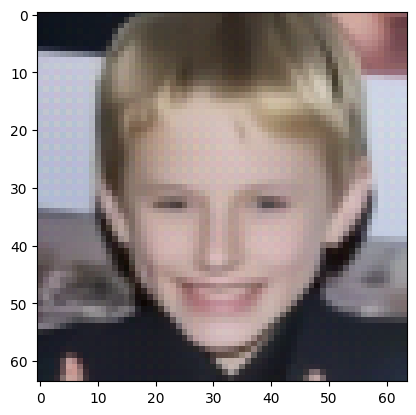

In [1078]:
plt.imshow(denoised_nf.squeeze().permute(1,2,0))

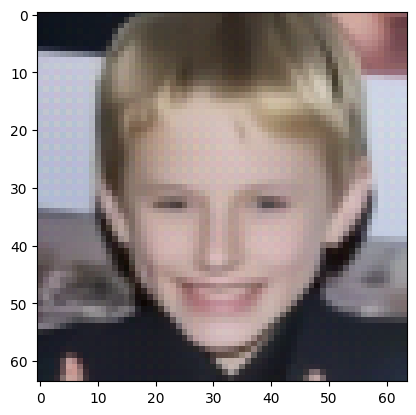

In [1079]:
plt.imshow(denoised_nf.squeeze().permute(1,2,0)) # 1.0

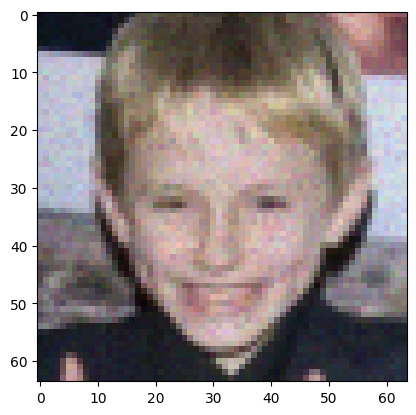

In [1080]:
plt.imshow(denoised_nl.squeeze().permute(1,2,0))

In [1028]:
clear = comparison_small[0]
alpha, var, denoised = comparison_small[0]['model'].get_params()

TypeError: tuple indices must be integers or slices, not str

In [939]:
alpha, var

(tensor(0.0099), tensor(0.0010))

In [897]:
(clear-denoised).abs().max()

tensor(0.0799)

In [898]:
(clear-denoised).pow(2).mean()

tensor(0.0004)

In [591]:
# comparison_small[0]['metrics']['ssim']

In [583]:
# plt.hist(X[0].log().flatten().numpy())

In [584]:
alpha

tensor(0.3238)

In [585]:
var

tensor(0.)

In [ ]:
noise_generator = PoissonGaussianNoise(0.01, 0.00001)
noisy = noise_generator(clear.repeat(10000,1,1,1))
(
    (noisy.mean(0) - clear).abs().max(),
    ((0.01 * clear + 0.00001).sqrt() - noisy.std(0)).max()
)

In [456]:
comparison_small[0]['model'].log_alpha

Parameter containing:
tensor(-0.4687, requires_grad=True)

In [457]:
comparison_small[0]['model'].log_sigma

Parameter containing:
tensor(-inf, requires_grad=True)

In [434]:
torch.tensor(0.001).sqrt().log()

tensor(-3.4539)

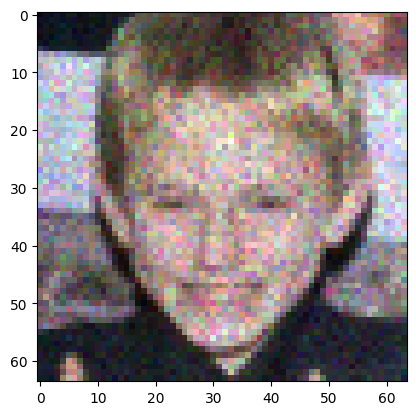

In [435]:
plt.imshow(PoissonGaussianNoise(0.01, 0.00001)(X[0].unsqueeze(0).repeat(3,1,1,1)).detach()[0].permute(1,2,0))

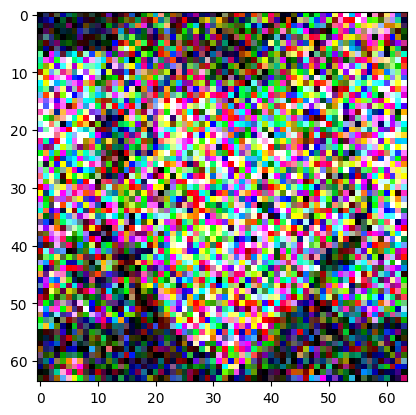

In [436]:
plt.imshow(PoissonGaussianNoise(alpha, var)(X[0].unsqueeze(0).repeat(3,1,1,1)).detach()[0].permute(1,2,0))

# Analysis of Convergence


In [39]:
for n_samples in [16, 32, 64, 128]:
    # for noise_params in [(256, 0.05), (256, 0.025), (256, 0.0), (512, 0.05), (512, 0.025), (512, 0.0)]:
    plt.plot(COMPARISON[(n_samples, noise_params, 'null')]['denoised'][0][True]['metadata']['log_likelihood'], label=f"{n_samples}")
plt.legend()
plt.title("Log-Likelihood for different sample size")
plt.xlabel('iteration')
plt.ylabel('value')

KeyError: (16, (512, 0.0), 'null')

In [40]:
for n_samples in [16, 32, 64, 128]:
    # for noise_params in [(256, 0.05), (256, 0.025), (256, 0.0), (512, 0.05), (512, 0.025), (512, 0.0)]:
    plt.plot(COMPARISON[(n_samples, noise_params, 'null')]['denoised'][0][True]['metadata']['log_prior'], label=f"{n_samples}")
plt.legend()
plt.title("Log-Likelihood for different sample size")
plt.xlabel('iteration')
plt.ylabel('value')

KeyError: (16, (512, 0.0), 'null')

In [41]:

d = {str(n_samples): COMPARISON[(n_samples, noise_params, 'null')]['denoised'][0][True]['metrics']['mse']['noisy'] 
            for n_samples in [16, 32, 64, 128]}
fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
plt.legend()
plt.title("Log-Likelihood for different sample size")
plt.xlabel('sample_size')
plt.ylabel('value')

KeyError: (16, (512, 0.0), 'null')

In [42]:
d = {str(n_samples): COMPARISON[(n_samples, (256, 0.05), 'null')]['denoised'][0][True]['metrics']['mse']['denoised'] 
            for n_samples in [16, 32, 64, 128]}
fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
plt.legend()
plt.title("Log-Likelihood for different sample size")
plt.xlabel('sample_size')
plt.ylabel('value')

KeyError: (16, (256, 0.05), 'null')

In [43]:
comparison_small['denoised'][0][True]['params']

NameError: name 'comparison_small' is not defined

In [44]:
Chat = comparison_small['denoised'][0][True]['params']['C']

NameError: name 'comparison_small' is not defined

In [45]:
Cnoisy = comparison_small['denoised'][0][True]['Ns'][0:1]

NameError: name 'comparison_small' is not defined

In [46]:
Ctrue = comparison_small['denoised'][0][True]['C']

NameError: name 'comparison_small' is not defined

In [865]:
A = comparison_small['denoised'][0][True]['params']['logA'].exp()

In [866]:
V = comparison_small['denoised'][0][True]['params']['logV'].exp()

In [867]:
A, V

(tensor(0.2674), tensor(0.0042))

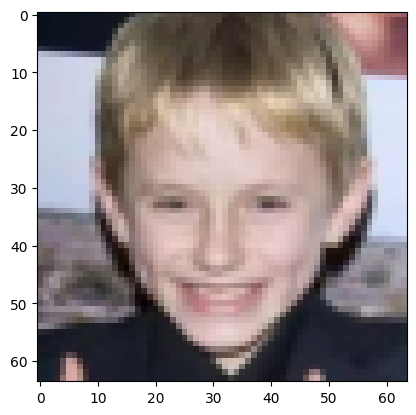

In [868]:
plt.imshow(fit_range(C.squeeze().permute(1,2,0).numpy()))

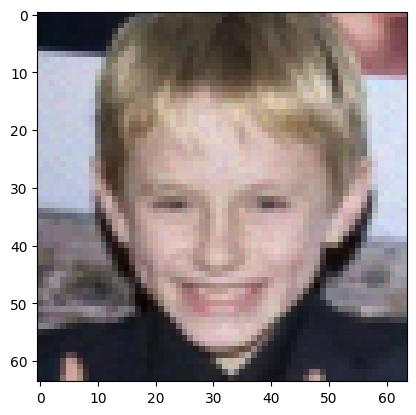

In [869]:
plt.imshow(fit_range(Chat.squeeze().permute(1,2,0).numpy()))

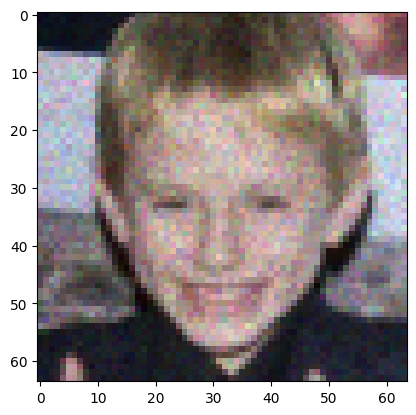

In [870]:
plt.imshow(fit_range(Cnoisy.squeeze().permute(1,2,0).numpy()))

In [871]:
noise_model = PoissonGaussianNoise(256, 0.05)

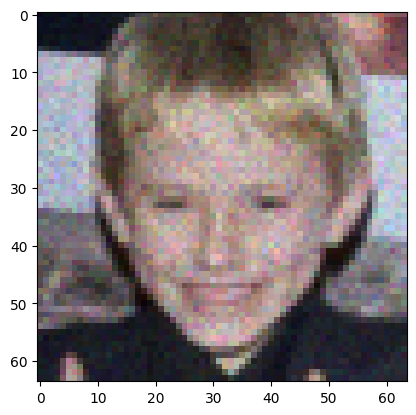

In [872]:
noise_model = PoissonGaussianNoise(256, 0.05)
plt.imshow(fit_range(noise_model(C.repeat(32,1,1,1))[0:1].squeeze().permute(1,2,0).numpy()))

In [412]:
_, _, z = model(noisy)


# z[0] = torch.randn_like(z[0])
# z[1] = torch.randn_like(z[1])
# z[2] = torch.randn_like(z[2])
# z[3] = torch.randn_like(z[3])

# z[0].zero_()
# z[1].zero_()
# z[2].zero_()
# z[3].zero_()

c = 5
z[0] /= c
z[1] /= c
z[2] /= c
z[3] /= c

denoised = reverse(model, z)

fig, ax = plt.subplots(1, 3, figsize=(15,30))

ax[0].imshow(fit_range(noisy.squeeze().permute(1,2,0).numpy()))
ax[1].imshow(fit_range(denoised.squeeze().permute(1,2,0).numpy()))
ax[2].imshow(fit_range(clear.squeeze().permute(1,2,0).numpy()))

NameError: name 'noisy' is not defined

In [ ]:
Policzyć:
- dla różnych beta
    - dla beta wskazanego przez model
- dla różnych gainów szumu


W pracy:
- wstęp teoretyczny 1 strona
- wyjaśnienie metody 0.5 strony
- tabelka - opis 0.5 strony
- zdjęcia - opis 0.5 strony
- bibliografia 0.5 strony 

# Test

In [549]:
delta = Delta(noisy)
opt = torch.optim.Adam(delta.parameters())

In [512]:
delta, metadata = denoise(model, preprocess(noisy), delta=delta, sigma=0.2, beta=4, iterations=250, device='cuda')

log_likelihood : -27622.72266  | log_prior = 52940.91016: 100%|███████████████████████████████████████████| 250/250 [01:08<00:00,  3.65it/s]


Text(0.5, 1.0, 'original')

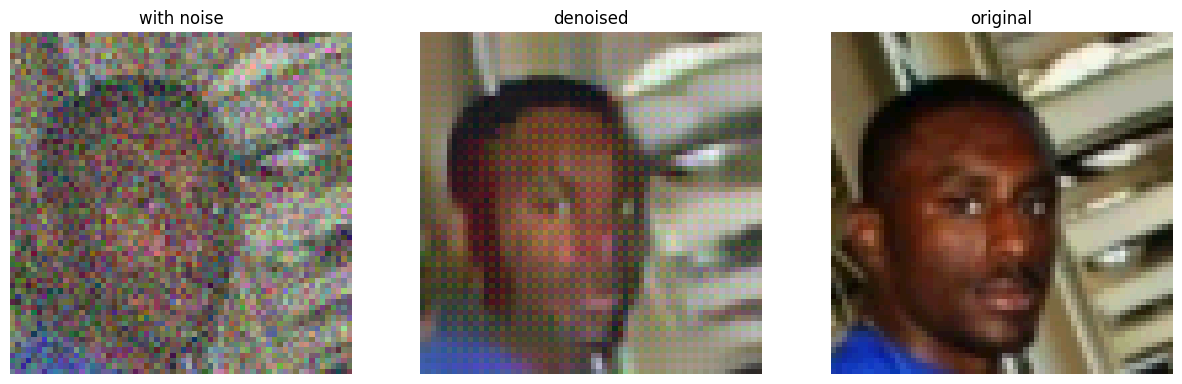

In [516]:
denoised = delta(preprocess(noisy)).detach()
denoised += 0.5
denoised[:, :, 1::2, 1::2] *= 1.00 - 0.1
denoised -= 0.5

fig, ax = plt.subplots(1,3, figsize=(15,30))

ax[0].imshow(fit_range(preprocess(noisy).squeeze().permute(1,2,0).numpy()))
ax[1].imshow(fit_range(denoised.squeeze().permute(1,2,0).numpy()))
ax[2].imshow(fit_range(preprocess(clear).squeeze().permute(1,2,0).numpy()))
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title('with noise')
ax[1].set_title('denoised')
ax[2].set_title('original')

# Comparison

In [949]:
compute_metrics(preprocess(noisy), denoised, preprocess(clear), measures)

{'mse': (0.11172015731813575, 0.2736267704561351),
 'psnr': (9.518684614211743, 5.628414153853005),
 'ssim': (0.2453788268828554, 0.010940612275346902)}

In [950]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def denoise_kmeans(noisy):
    rgb_img = noisy.clip(0, 1).squeeze().permute(1,2,0).numpy()
    img = torch.stack([noisy[0, 0], noisy[0, 1], noisy[0, 2]]).clip(0, 1).permute(1, 2, 0).numpy()
    
    img = np.uint8(img * 255)
    rgb_img = np.uint8(rgb_img * 255)
    
    # Denoising
    dst = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
    b,g,r = cv2.split(dst)           # get b, g, r
    rgb_dst = cv2.merge([r,g,b])     # switch it to rgb
    denoised = torch.tensor(dst / 255, dtype=torch.float32).permute(2, 0, 1)
    return denoised

In [951]:
denoised = denoise_kmeans(noisy)

Text(0.5, 1.0, 'original')

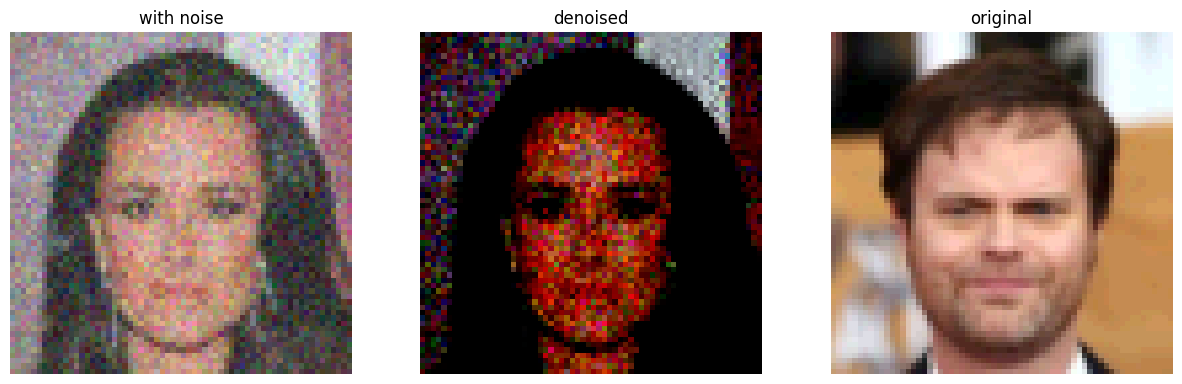

In [952]:
fig, ax = plt.subplots(1,3, figsize=(15,30))

ax[0].imshow(fit_range(noisy.squeeze().permute(1,2,0).numpy()))
ax[1].imshow(fit_range(denoised.squeeze().permute(1,2,0).numpy()))
ax[2].imshow(fit_range(clear.squeeze().permute(1,2,0).numpy()))
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title('with noise')
ax[1].set_title('denoised')
ax[2].set_title('original')

In [368]:
compute_metrics(preprocess(noisy), preprocess(denoised), preprocess(clear), measures)

{'mse': (0.0011627027274410014, 0.0008087972291142189),
 'psnr': (29.345313087752643, 30.921603452786602),
 'ssim': (0.7863326211627152, 0.8605434295608051)}

In [626]:
model = model.cpu()

In [630]:
len(model.blocks)

4

In [633]:
len(model.blocks[0].flows)

32

In [637]:
len(model.blocks[1].flows)

32

In [638]:
len(model.blocks[2].flows)

32

In [639]:
len(model.blocks[3].flows)

32

# Small Analysis

In [641]:
len(comparison_small)

32

tensor([[[[-0.4688, -0.4688, -0.4688,  ...,  0.0938,  0.0625,  0.0312],
          [-0.4688, -0.4688, -0.4688,  ..., -0.0312, -0.0625, -0.0938],
          [-0.4688, -0.4688, -0.4688,  ..., -0.0625, -0.0938, -0.1250],
          ...,
          [-0.4062, -0.4375, -0.4062,  ..., -0.3438, -0.3438, -0.3750],
          [-0.4062, -0.4375, -0.4062,  ..., -0.3438, -0.3438, -0.3750],
          [-0.4062, -0.4062, -0.4062,  ..., -0.3750, -0.3750, -0.3438]],

         [[-0.4375, -0.4375, -0.4375,  ..., -0.1250, -0.1250, -0.1562],
          [-0.4375, -0.4375, -0.4375,  ..., -0.2188, -0.2500, -0.2812],
          [-0.4375, -0.4375, -0.4375,  ..., -0.2188, -0.2500, -0.2500],
          ...,
          [-0.3750, -0.3750, -0.3750,  ..., -0.3125, -0.3125, -0.3438],
          [-0.3750, -0.3750, -0.3750,  ..., -0.3438, -0.3125, -0.3438],
          [-0.3750, -0.3750, -0.3750,  ..., -0.3438, -0.3438, -0.3438]],

         [[-0.3750, -0.3750, -0.3750,  ..., -0.1250, -0.0938, -0.1250],
          [-0.4062, -0.4062, -

# Metrics

In [957]:
keys = sorted(comparison_small[0]['deltas'][0].keys())

In [1022]:

def get_table(measure='ssim'):
    betas = [1,2,4,8]
    sigmas = [0.025, 0.05]
    s = [""]
    def print(a, b='', end='\n'):
        s[0] += a
        s[0] += b
        s[0] += end
        
    print('\\toprule')
    print("$\sigma$ & $\\beta=1$ & $\\beta=2$ & $\\beta=4$ & $\\beta=8$ & noisy \\\\")
    print("\\midrule")
    for i in range(2):
        print(f' ${sigmas[i]}$' , end=' & ')
        for j in range(4):
            temp = [100*c['deltas'][0][(sigmas[i], betas[j])]['metrics'][measure][1] for c in comparison_small]
            print(f"${np.mean(temp):.03f} \pm {np.std(temp):.02f} $", end=' & ')
            
        temp = [100*c['deltas'][0][(sigmas[i], betas[j])]['metrics'][measure][0] for c in comparison_small]
        print(f"${np.mean(temp):.03f} \pm {np.std(temp):.02f} $", ' \\\\')
        # print(f"${comparison_small[0]['deltas'][0][(sigmas[i], betas[j])]['metrics']['ssim'][0]:.03f}$", ' \\\\')
    
    sigmas = [0.1, 0.2]
    for i in range(2):
        print(f' ${sigmas[i]}$' , end=' & ')
        for j in range(4):
            if betas[j] in [2,8]:
                print(' - ', end=' & ')
                continue
            temp = [100*c['deltas'][0][(sigmas[i], betas[j])]['metrics'][measure][1] for c in comparison_big]
            # print(f"{comparison_big[0]['deltas'][0][(sigmas[i], betas[j])]['metrics']['ssim'][1]:.05f}", end=' & ')
            print(f"${np.mean(temp):.03f} \pm {np.std(temp):.02f} $", end=' & ')
        
        temp = [100*c['deltas'][0][(sigmas[i], betas[0])]['metrics'][measure][0] for c in comparison_big]
        print(f"${np.mean(temp):.03f} \pm {np.std(temp):.02f} $", ' \\\\')
        # print(f"${comparison_big[0]['deltas'][0][(sigmas[i], betas[0])]['metrics']['ssim'][0]:.03f}$", ' \\\\')
    print('\\bottomrule')

    return s[0].replace('0.', '.')

In [1023]:
print(get_table('ssim'))

\toprule
$\sigma$ & $\beta=1$ & $\beta=2$ & $\beta=4$ & $\beta=8$ & noisy \\
\midrule
 $.025$ & $96.409 \pm 1.44 $ & $98.108 \pm .71 $ & $97.647 \pm .64 $ & $96.299 \pm 1.29 $ & $94.911 \pm 1.95 $ \\
 $.05$ & $89.911 \pm 3.13 $ & $93.190 \pm 2.70 $ & $94.254 \pm 2.57 $ & $88.147 \pm 3.43 $ & $85.443 \pm 4.20 $ \\
 $.1$ & $68.932 \pm 5.91 $ &  -  & $84.085 \pm 5.64 $ &  -  & $67.810 \pm 6.23 $ \\
 $.2$ & $65.696 \pm 7.08 $ &  -  & $55.743 \pm 6.66 $ &  -  & $43.792 \pm 6.71 $ \\
\bottomrule



In [1024]:
print(get_table('psnr'))

\toprule
$\sigma$ & $\beta=1$ & $\beta=2$ & $\beta=4$ & $\beta=8$ & noisy \\
\midrule
 $.025$ & $3742.418 \pm 67.13 $ & $3938.908 \pm 57.59 $ & $3822.763 \pm 46.72 $ & $368.634 \pm 22.51 $ & $3552.960 \pm 8.18 $ \\
 $.05$ & $3217.068 \pm 44.33 $ & $3415.443 \pm 46.27 $ & $3397.558 \pm 73.10 $ & $3069.257 \pm 16.24 $ & $2952.380 \pm 9.12 $ \\
 $.1$ & $252.362 \pm 39.17 $ &  -  & $2907.132 \pm 10.88 $ &  -  & $2349.498 \pm 11.51 $ \\
 $.2$ & $2293.484 \pm 114.90 $ &  -  & $2064.075 \pm 47.55 $ &  -  & $1748.612 \pm 8.64 $ \\
\bottomrule



In [1025]:
print(get_table('mse'))

\toprule
$\sigma$ & $\beta=1$ & $\beta=2$ & $\beta=4$ & $\beta=8$ & noisy \\
\midrule
 $.025$ & $.018 \pm .00 $ & $.012 \pm .00 $ & $.015 \pm .00 $ & $.021 \pm .00 $ & $.028 \pm .00 $ \\
 $.05$ & $.061 \pm .01 $ & $.039 \pm .00 $ & $.041 \pm .01 $ & $.085 \pm .00 $ & $.112 \pm .00 $ \\
 $.1$ & $.303 \pm .03 $ &  -  & $.128 \pm .03 $ &  -  & $.447 \pm .01 $ \\
 $.2$ & $.528 \pm .16 $ &  -  & $.868 \pm .10 $ &  -  & $1.784 \pm .04 $ \\
\bottomrule



In [959]:
key = (0.05, 4)

In [747]:
comparison_small[0]['deltas'][0][key]['metrics']

{'mse': (0.001072243645389896, 0.00041584377576874877),
 'psnr': (29.697065189105544, 33.81069794528115),
 'ssim': (0.893854022234253, 0.955208300924046)}

# Comparison for different betas 

In [793]:
from matplotlib import rc
import matplotlib.pylab as plt

# rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})
# rc('text', usetex=True)

plt.rcdefaults()

In [852]:
ith = 4
std = 0.05
clear = comparison_small[ith]['clear']
noisy = comparison_small[ith]['deltas'][0][(std, 1)]['noisy']
denoised_1 = comparison_small[ith]['deltas'][0][(std, 1)]['denoised']
denoised_2 = comparison_small[ith]['deltas'][0][(std, 2)]['denoised']
denoised_4 = comparison_small[ith]['deltas'][0][(std, 4)]['denoised']
denoised_8 = comparison_small[ith]['deltas'][0][(std, 8)]['denoised']

Text(0.5, 1.0, 'original')

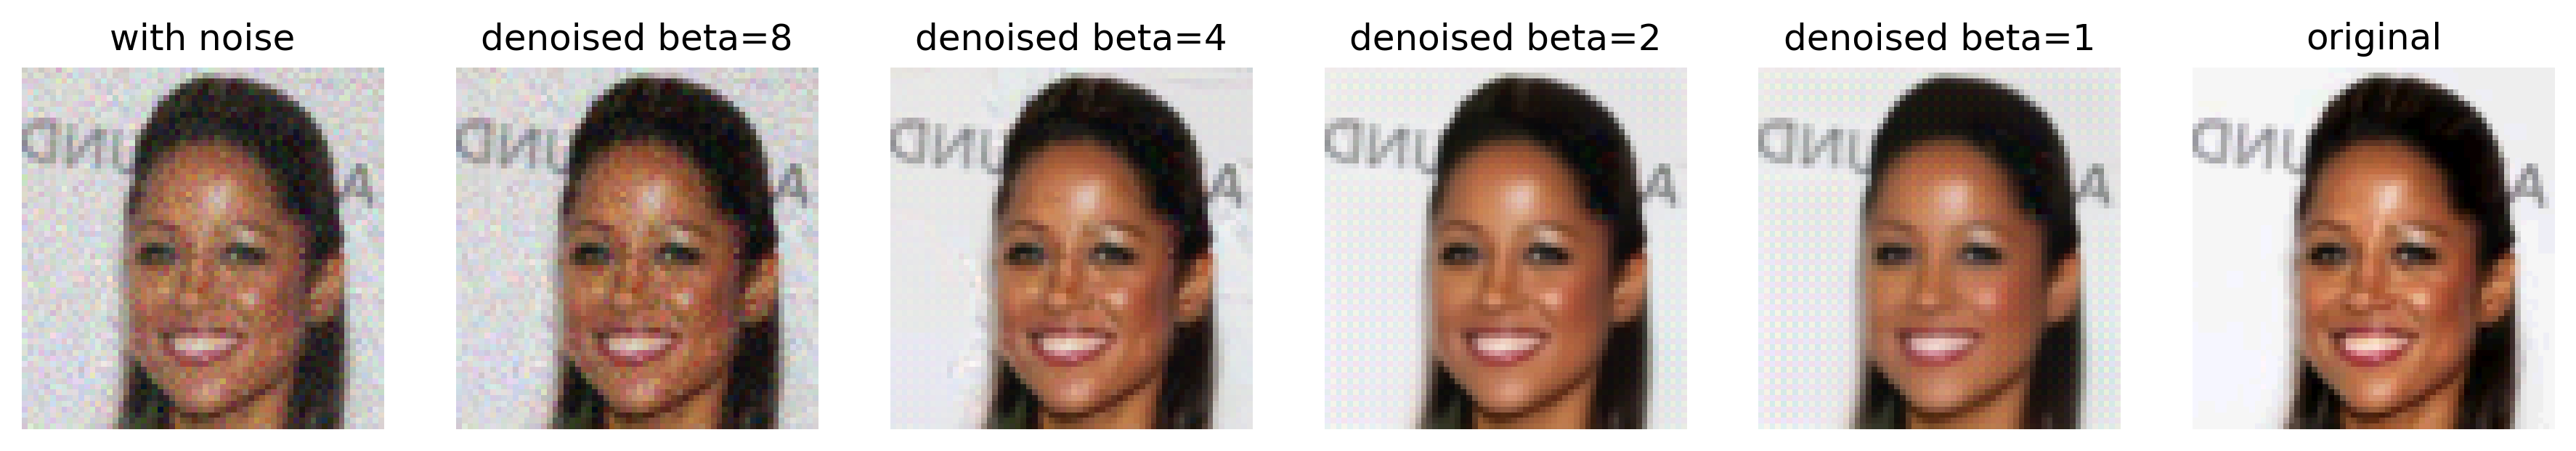

In [853]:


fig, ax = plt.subplots(1,6, figsize=(15,60), dpi=300)

ax[0].imshow(fit_range(noisy.squeeze().permute(1,2,0).numpy()))
ax[1].imshow(fit_range(denoised_8.squeeze().permute(1,2,0).numpy()))
ax[2].imshow(fit_range(denoised_4.squeeze().permute(1,2,0).numpy()))
ax[3].imshow(fit_range(denoised_2.squeeze().permute(1,2,0).numpy()))
ax[4].imshow(fit_range(denoised_1.squeeze().permute(1,2,0).numpy()))
ax[5].imshow(fit_range(clear.squeeze().permute(1,2,0).numpy()))
for a in ax:
    a.axis('off')
ax[0].set_title('with noise')
for i in range(4):
    ax[i+1].set_title(f'denoised beta={2**(3-i)}')
ax[5].set_title('original')

In [1050]:
ith = 25
clear = comparison_small[ith]['clear']
key_1 = (0.025, 2)
key_2 = (0.05, 2)
noisy_1 = comparison_small[ith]['deltas'][0][key_1]['noisy']
denoised_1 = comparison_small[ith]['deltas'][0][key_1]['denoised']
noisy_2 = comparison_small[ith]['deltas'][0][key_2]['noisy']
denoised_2 = comparison_small[ith]['deltas'][0][key_2]['denoised']

Text(0.5, 1.0, 'original')

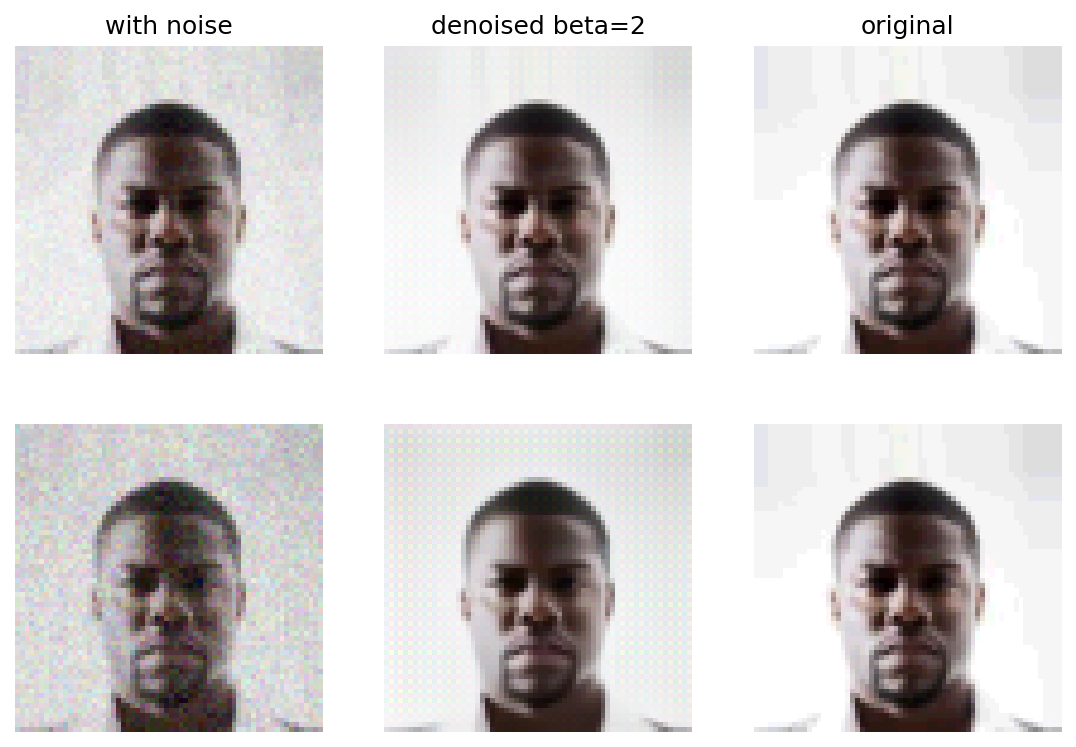

In [1051]:
fig, ax = plt.subplots(2,3, figsize=(9,6), dpi=150)

ax[0][0].imshow(fit_range(noisy_1.squeeze().permute(1,2,0).numpy()))
ax[0][1].imshow(fit_range(denoised_1.squeeze().permute(1,2,0).numpy()))
ax[0][2].imshow(fit_range(clear.squeeze().permute(1,2,0).numpy()))
ax[1][0].imshow(fit_range(noisy_2.squeeze().permute(1,2,0).numpy()))
ax[1][1].imshow(fit_range(denoised_2.squeeze().permute(1,2,0).numpy()))
ax[1][2].imshow(fit_range(clear.squeeze().permute(1,2,0).numpy()))
for a in ax:
    for a in a:
        a.axis('off')
ax[0][0].set_title('with noise')
ax[0][1].set_title('denoised beta=2')
ax[0][2].set_title('original')

# Noise Gain

In [919]:
ith = 31
clear = comparison_big[ith]['clear']
key_1 = (0.025, 4)
key_2 = (0.05, 4)
s_noisy_1 = comparison_small[ith]['deltas'][0][key_1]['noisy']
s_denoised_1 = comparison_small[ith]['deltas'][0][key_1]['denoised']
s_noisy_2 = comparison_small[ith]['deltas'][0][key_2]['noisy']
s_denoised_2 = comparison_small[ith]['deltas'][0][key_2]['denoised']
key_1 = (0.1, 4)
key_2 = (0.2, 1)
b_noisy_1 = comparison_big[ith]['deltas'][0][key_1]['noisy']
b_denoised_1 = comparison_big[ith]['deltas'][0][key_1]['denoised']
b_noisy_2 = comparison_big[ith]['deltas'][0][key_2]['noisy']
b_denoised_2 = comparison_big[ith]['deltas'][0][key_2]['denoised']

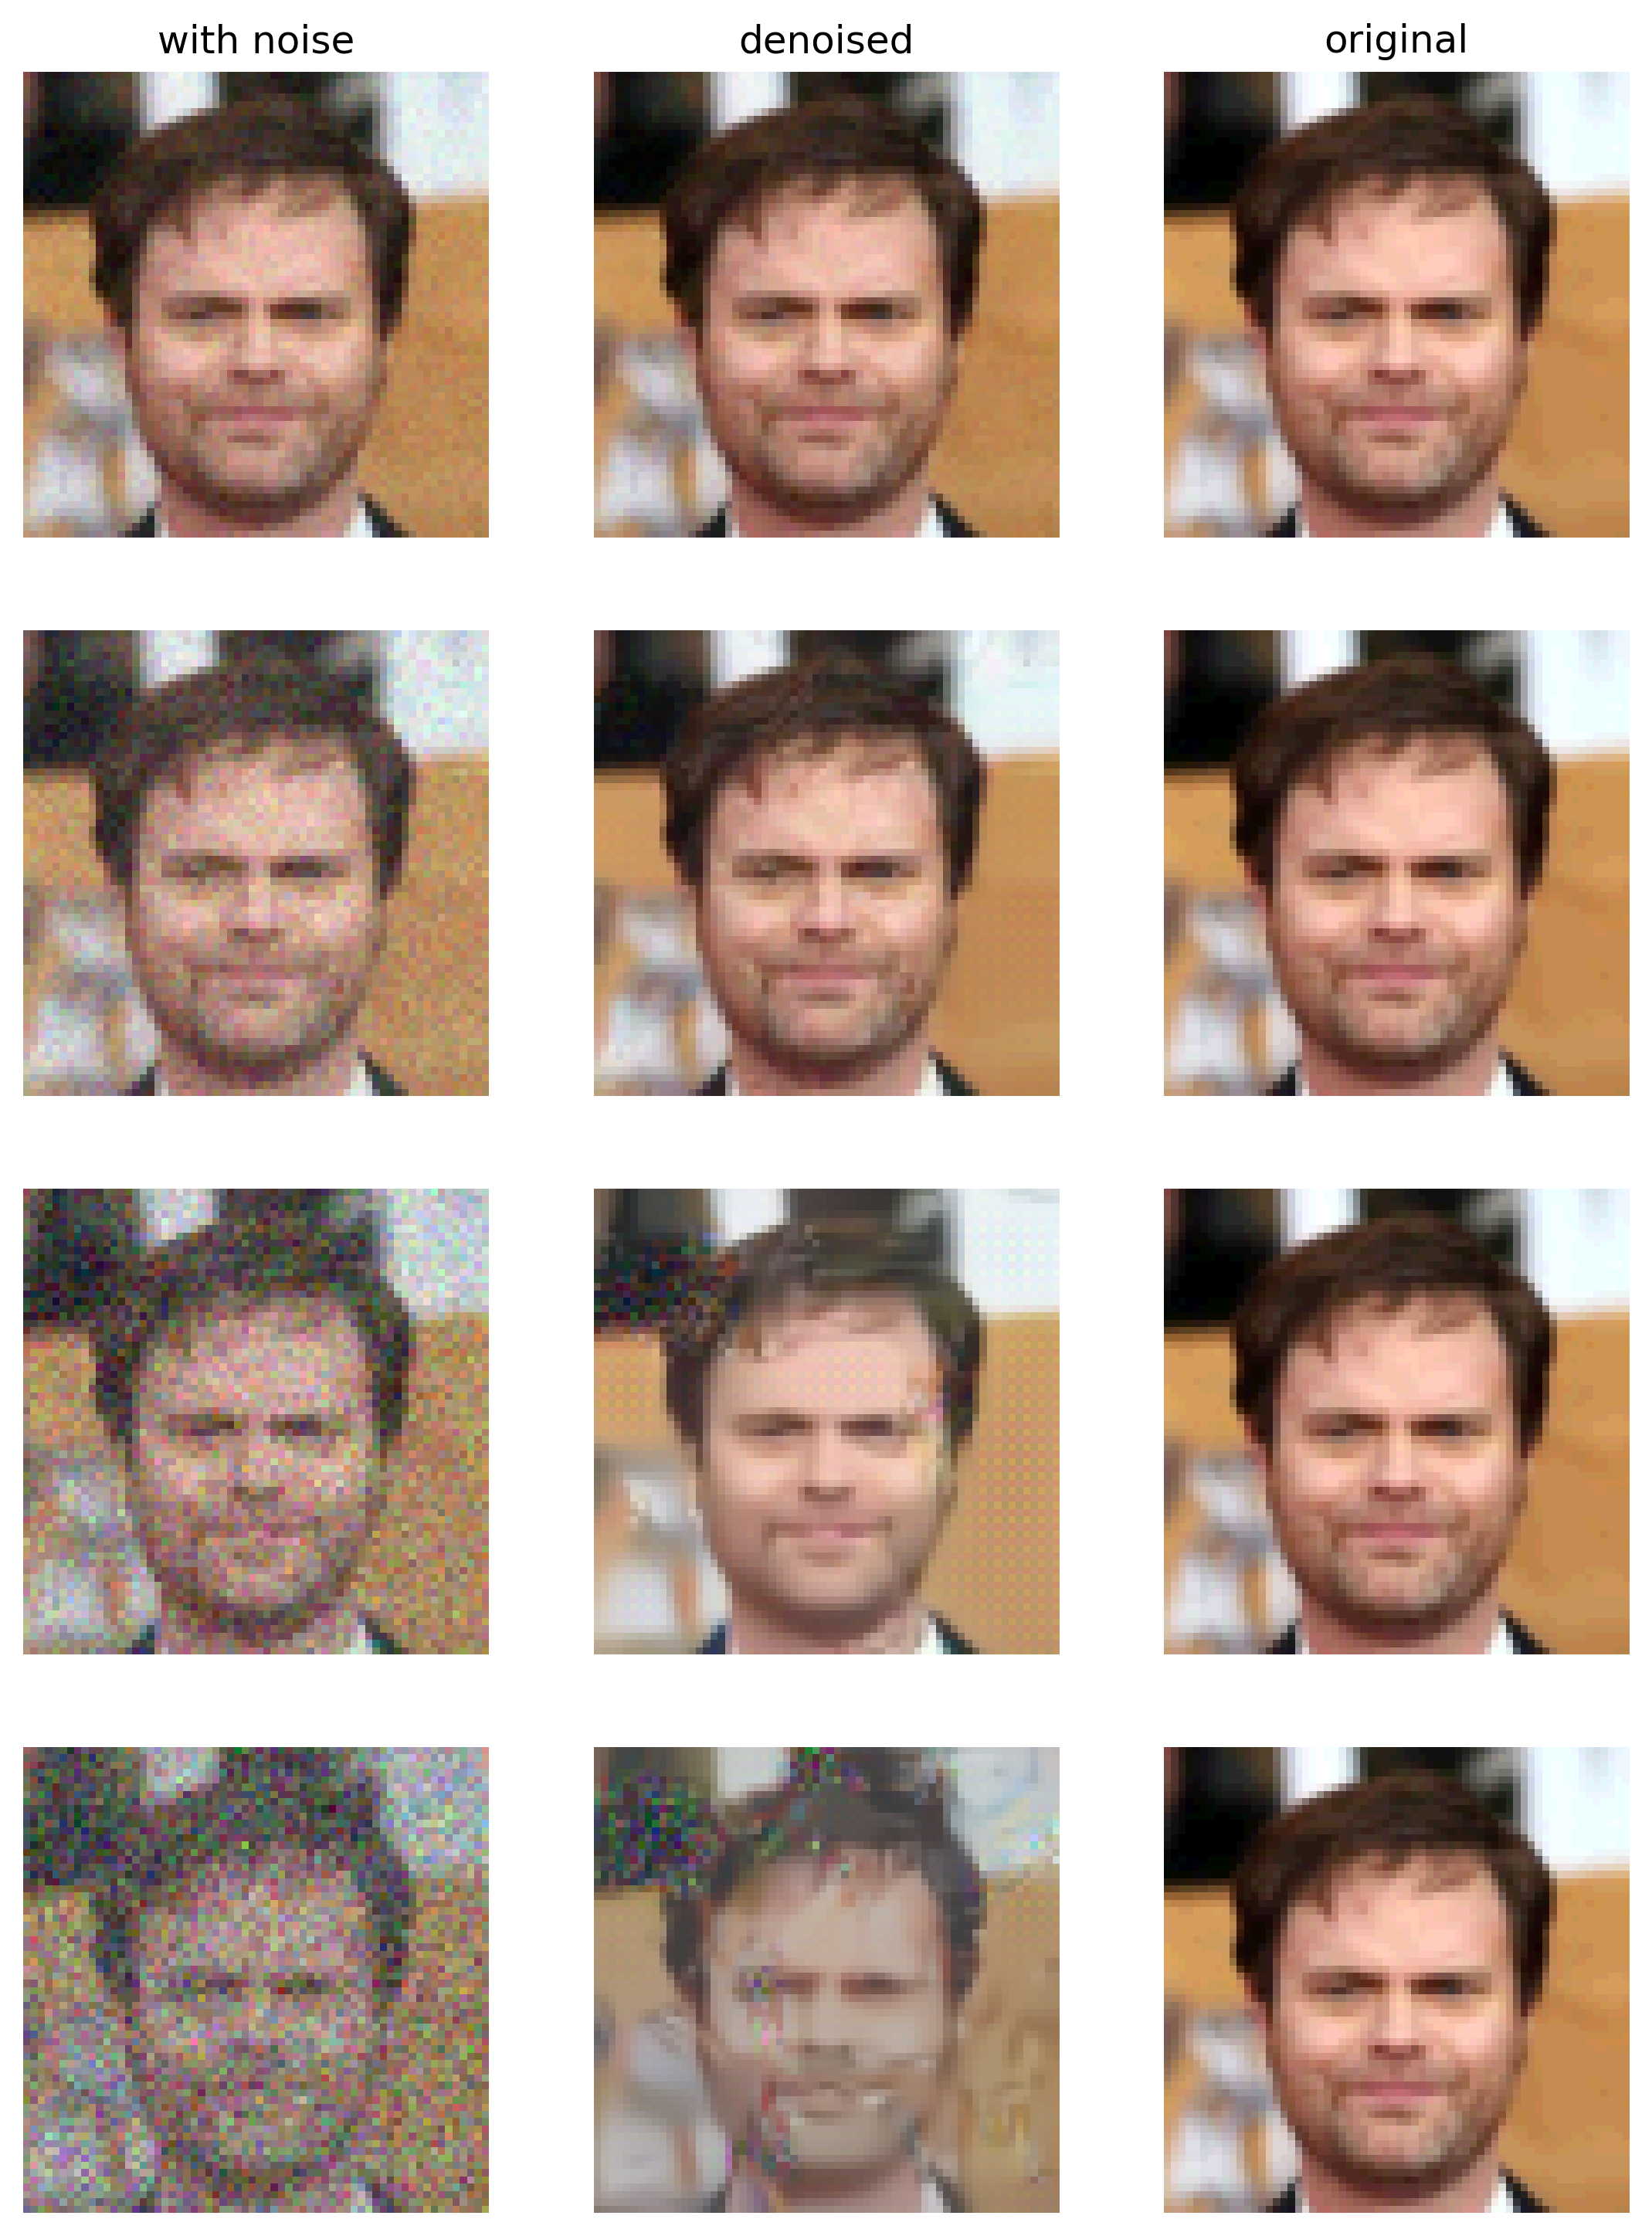

In [921]:
fig, ax = plt.subplots(4, 3, figsize=(9,12), dpi=300)

ax[0][0].imshow(fit_range(s_noisy_1.squeeze().permute(1,2,0).numpy()))
ax[0][1].imshow(fit_range(s_denoised_1.squeeze().permute(1,2,0).numpy()))
ax[0][2].imshow(fit_range(clear.squeeze().permute(1,2,0).numpy()))
ax[1][0].imshow(fit_range(s_noisy_2.squeeze().permute(1,2,0).numpy()))
ax[1][1].imshow(fit_range(s_denoised_2.squeeze().permute(1,2,0).numpy()))
ax[1][2].imshow(fit_range(clear.squeeze().permute(1,2,0).numpy()))

ax[2][0].imshow(fit_range(b_noisy_1.squeeze().permute(1,2,0).numpy()))
ax[2][1].imshow(fit_range(b_denoised_1.squeeze().permute(1,2,0).numpy()))
ax[2][2].imshow(fit_range(clear.squeeze().permute(1,2,0).numpy()))
ax[3][0].imshow(fit_range(b_noisy_2.squeeze().permute(1,2,0).numpy()))
ax[3][1].imshow(fit_range(b_denoised_2.squeeze().permute(1,2,0).numpy()))
ax[3][2].imshow(fit_range(clear.squeeze().permute(1,2,0).numpy()))

for a in ax:
    for a in a:
        a.axis('off')
ax[0][0].set_title('with noise')
ax[0][1].set_title('denoised')
ax[0][2].set_title('original')

plt.savefig('different_gains.png')

In [ ]:
# params = {
        #     'C': torch.nn.Parameter(Ns.mean(0, keepdim=True).detach(), requires_grad=True),
        #     'logA': torch.nn.Parameter(torch.tensor([0.0]).detach(), requires_grad=True),
        #     'logV': torch.nn.Parameter(torch.tensor([0.0]).detach(), requires_grad=True),
        # }

        # params = {
        #     'C': Ns.mean(0, keepdim=True).to(device).detach().requires_grad_(), 
        #     'logA': torch.tensor(-2.0).to(device).detach().requires_grad_(),
        #     'logV': torch.tensor(-6.0).to(device).detach().requires_grad_(),
        # }
        
        # for p in params.values():
        #     print(p.is_leaf)
        

In [ ]:
        # Log Likelihood
        # Sigma = logA.mul(2).exp() * C + logV.exp()
        
        # log_likelihood = - 0.5 * (Ns.shape[0] * Sigma.log().sum() + (Ns - logA.exp() * C).pow(2).sum(0, keepdim=True).mul(Sigma.pow(-1)).sum())